#ResNet18 로 명화 분류

dataset: kaggle의 해당 코드에 있는 dataset https://www.kaggle.com/code/yasamanasgary/best-artworks-artist-predition-via-pytorch/notebook 

model : Resnet18(weight)      <--  Resnet에 class마다의 가중치값 적용한 모델

명화분류로 해당 모델이 그림 분류에 괜찮은지 확인용 -> accuracy 75나왔고 epoch마다 증가하고 있으니까 괜찮은듯

10개의 class로 분류

# 1. 필요 라이브러리 임포트

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline


# 데이터 불러오기
10개의 화가 그림있는 디렉터리 가져오기

temp_art 디렉토리

temp_art/

|-- Alfred_Sisley/

    |-- Alfred_Sisley_0.jpg

    |-- Alfred_Sisley_1.jpg

    |-- Alfred_Sisley_2.jpg

    |-- ...

|-- Edgar_Degas/

    |-- Edgar_Degas_0.jpg

    |-- Edgar_Degas_1.jpg

    |-- Edgar_Degas_2.jpg

    |-- ...
.
.
.


*dataset.ImageFolder(images_dir) : 계층적 폴더 구조를 가진 dataset 을 가져올 때 사용
각 이미지들이 자신의 레이블(Label) 이름으로 된 폴더 안에 들어가 있는 구조일 때

<참고> torchvision.datasets : 특징(feature) 와 정답(label)을 저장

** transforms.Compose() : augmentation을 위한 이미지 변환을 한번에 적용할 수 있는 메서드, 해당 부분은 테스트해가면서 조정하기

[https://pytorch.org/vision/stable/transforms.html](https://pytorch.org/vision/stable/transforms.html)

`transforms.ToTensor()` : PIL image나 numpy.ndarray를 tensor로 변환한다. 

- PIL image(pillow)
    
    파이썬에서 이미지를 핸들링하기 위한 패키지(opencv같은 거) 인 PIL로 받은 image
    

[`normalize(tensor, mean, std[, inplace])` **:** float인 tensor image를 mean과 standard deviation으로 normalize한다.

[`RandomCrop](size[, padding, pad_if_needed, …])`  **:** 랜덤 위치에서 주어진 이미지를 crop한다.

[`RandomHorizontalFlip]([p])` **:** 입력된 probability로 랜덤 수평뒤집기



In [4]:
images_dir = '/content/drive/MyDrive/ml_workplace/YeZak/YeZak_Dataset'

transform = transforms.Compose([ 
      transforms.Resize((100,100)),   
      transforms.ToTensor()])
dataset = ImageFolder(images_dir, transform = transform)   #from torchvision.datasets import ImageFolder
dataset.classes


['동양화', '사실주의_인상주의', '애니메이션', '추상화_큐비즘_팝아트']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


데이터셋 잘 불러왔는지 확인

transpose(a,b) : a차원과 b차원을 교환 


In [5]:
def visualize_sample(sample):
    print("Class is:", sample[1])
    plt.imshow(sample[0].transpose(0, 1).transpose(1, 2))    # sample[0] 텐서는 (3, 100, 100) 으로 [channel, width, height] 인데, imshow의 인자는 [height, width, channel]순이여야함 

Class is: 0


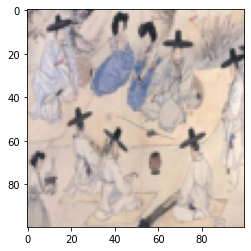

In [6]:
visualize_sample(dataset[0])

Class is: 1


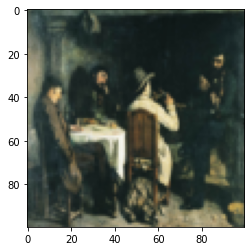

In [7]:
visualize_sample(dataset[500])

#검증을 위한 데이터 분할

In [8]:
train_length = round(len(dataset) * 0.7)
val_length = len(dataset) - train_length             #3971data 중 70퍼가 train data, 30퍼가 test data
train, val = random_split(dataset, [train_length, val_length])      #datase   t에서 랜덤하고 겹치지 않게 주어진 길이만큼 이미지는 쪼갠다 
print(len(dataset)) 

1068


Class is: 3


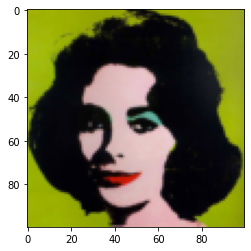

In [9]:
visualize_sample(train[0])        #랜덤하게 나눴으니까 실행마다 바뀜

Class is: 0


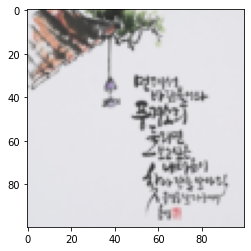

In [10]:
visualize_sample(val[0])

#모델 학습 준비

In [11]:
#gpu 사용 가능한지 확인하기

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"    #colab GPU사용량 초과해서 cpu사용 -> false출력
    
print(torch.cuda.is_available())

True


resnet18('Weights','none') : weights: class에 대한 가중치(입력안하니까 정확도 낮아서 입력함),  pretrained = none :  pretrained = True 면 다른 큰 데이터셋에서 train되었던 resnet 을 가져옴

In [21]:
def get_files_count(folder_path):
  dirListing = os.listdir(folder_path)
  return len(dirListing)

if __name__ =="__main__":
  print(get_files_count("."))

3


In [14]:
datapath_1 = "/content/drive/MyDrive/ml_workplace/YeZak/YeZak_Dataset/동양화"
datapath_2 = "/content/drive/MyDrive/ml_workplace/YeZak/YeZak_Dataset/사실주의_인상주의"
datapath_3 = "/content/drive/MyDrive/ml_workplace/YeZak/YeZak_Dataset/애니메이션"
datapath_4 = "/content/drive/MyDrive/ml_workplace/YeZak/YeZak_Dataset/추상화_큐비즘_팝아트"

In [39]:
weight_1 = get_files_count(datapath_1)
weight_2 = get_files_count(datapath_2)
weight_3 = get_files_count(datapath_3)
weight_4 = get_files_count(datapath_4)

arts_num = {'name' : ['동양화', '사실주의_인상주의', '애니메이션', '추상화_큐비즘_팝아트'],
               'num' : [weight_1, weight_2, weight_3, weight_4]}

arts = pd.DataFrame(arts_num)

#print(arts)

arts['class_weight'] = arts.num.sum() / (arts.shape[0] * arts.num)

print(arts)

arts_weights = arts['class_weight'].to_dict() 

print(arts_weights)

model = models.resnet18(arts_weights).to(device)   #resnet 18사용, weight 입력

          name  num  class_weight
0          동양화  282      0.946809
1    사실주의_인상주의  304      0.878289
2        애니메이션  200      1.335000
3  추상화_큐비즘_팝아트  282      0.946809
{0: 0.9468085106382979, 1: 0.8782894736842105, 2: 1.335, 3: 0.9468085106382979}


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [40]:
criterion = torch.nn.CrossEntropyLoss()   #손실함수(loss function) 선택, 예측값과 실제값의 차이를 구한다.
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)  # 최적화 모델 선택, 모델의 매개변수(model.parameters())를 조정해서 모델을 최적화 시킨다.        

#optim.SGD : 옵티마이저 중 stochastic gradient descent
#lr : learning rate     낮으면 학습 느리고, 너무 크면 overfitting 일어나서 오차 커짐
#속도 느려서 lr 0.01로 하니까 overfitting 일어남. 0.001이 딱 좋은듯=> 추후조정

In [41]:
BATCH_SIZE = 16     #GPU안돌아가서 배치 32-> 16으로 줄임
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)

#batch : 학습의 한 반복자(iter)를 epoch이라 하는데, 한 epoch에 들어가는 data의 수를 batchsize 라 한다
#DataLoader : batchsize 에 맞게 iterable한 객체로 dataset 에 접근한다.  -> for x, y in dataloader 표현 가능 


In [42]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

#모델 평가

In [43]:
def get_accuracy(model, loader):   #모델의 정확도를 구하는 함수
    model.eval()                  #resnet과 같은 model은 eval() <- 평가모드 와 train() <- 학습모드로 지정함에 따라 필요한 매개변수를 키고 끌 수 있으니 항상 적절하게 바꿔줘야함
    total = 0                     #loader의 전체 데이터수를 담을 변수
    correct = 0                   #모델의 정확도를 담을 변수
    for x, y in tqdm(loader):     # dataloader는 한 iter에 batchsize 만큼의 데이터를 가져옴, 만약 batchsize가 k라면   x : feature [k, 10, , ] <-- 10은 class수   y : lable [k] 의 size를 가질거임  
        x = x.to(device)

        y = y.to(device)
        
        pred = model(x)           #feature을 model에 넣어 prediction값 구하기, 
        total += y.shape[0]       #shape[0] : 행의 갯수, 즉 batchsize가 됨
        correct += (y == pred.argmax(1)).sum().item()     #일치정도를 구하는 방법 : pred.argmax(1) => pred의 1차원 ([k, 10, , ]에서 10인 class에 해당)중 값이 가장 큰 것이 몇 번째인지 알려줌. 즉 측정한 class알려줌
                                                          #y은 label이니까 한 batch의 k개의 데이터 중 label = 예측값 인거 찾기
                                                          #.sum()은 해당 조건 만족하는 갯수, .item()은 scalar 값으로 표현
        
        #print("pred.argmax(1) = ", pred.argmax(1))
        
        #print("pred.argmax(1).size = ", pred.argmax(1).size())
        
        #print("pred.argmax(1).max = ", pred.argmax(1).max())
        
        #print("y ", y)   디버그용
        
    return correct / total          #예측과 일치한 데이터 수 / 전체 데이터 수

In [44]:
get_accuracy(model, val_loader)         # train전에 확인



100%|██████████| 20/20 [03:06<00:00,  9.31s/it]


0.0

#모델 학습

학습 3단계 1. optimizer초기화, 2. loss.backwards() <- background propagation 3. optimizer.step()가중치갱신

In [45]:
def train_epoch(model, loader):      #한 epoch에 모델학습하는 함수
    total = 0
    correct = 0
    total_loss = 0
    for x, y in tqdm(loader):
        optimizer.zero_grad()      # optimizer 파라미터 초기화    
        x = x.to(device)
        y = y.to(device)
        pred = model(x)           #예측값
        loss = criterion(pred, y)     #loss계산하고
        loss.backward()             # background propagation   각 매개변수에 대한 손실의 변화도 저장

        total += y.shape[0]
        correct += (y == pred.argmax(1)).sum().item()
        total_loss += loss.item()

        optimizer.step()        #background propagation 결과로 parameter새로 업뎃

    accuracy = correct / total
    average_loss = total_loss / len(loader)
    
    return accuracy, average_loss

In [46]:
best_val_acc = 0
for epoch in range(20):
    
    print("Epoch {}".format(epoch + 1).center(40).center(80, "#"))
    train_acc, train_loss = train_epoch(model, train_loader)
    val_acc = get_accuracy(model, val_loader)
    
    print("train_acc={:.5f} train_loss={:.5f} val_acc={:.5f}".format(train_acc, train_loss, val_acc))
    
    if val_acc > best_val_acc:            # 만약 새로운 epoch에 더 좋은 정확도 나오면 모델 새로 저장
        best_val_acc = val_acc
        torch.save(model.state_dict(), "model.pt")
        print("Saved model to `model.pt`")

####################                Epoch 1                 ####################


100%|██████████| 20/20 [00:04<00:00,  4.79it/s]


train_acc=0.46658 train_loss=1.84156 val_acc=0.45937
Saved model to `model.pt`
####################                Epoch 2                 ####################


100%|██████████| 20/20 [00:04<00:00,  4.69it/s]


train_acc=0.77941 train_loss=0.62337 val_acc=0.67188
Saved model to `model.pt`
####################                Epoch 3                 ####################


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


train_acc=0.78743 train_loss=0.58597 val_acc=0.70000
Saved model to `model.pt`
####################                Epoch 4                 ####################


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


train_acc=0.85561 train_loss=0.42852 val_acc=0.82500
Saved model to `model.pt`
####################                Epoch 5                 ####################


100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


train_acc=0.88636 train_loss=0.31736 val_acc=0.70000
####################                Epoch 6                 ####################


100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


train_acc=0.87834 train_loss=0.30923 val_acc=0.82812
Saved model to `model.pt`
####################                Epoch 7                 ####################


100%|██████████| 20/20 [00:04<00:00,  4.75it/s]


train_acc=0.93048 train_loss=0.21015 val_acc=0.81250
####################                Epoch 8                 ####################


100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


train_acc=0.94385 train_loss=0.16700 val_acc=0.81563
####################                Epoch 9                 ####################


100%|██████████| 20/20 [00:04<00:00,  4.74it/s]


train_acc=0.94385 train_loss=0.17346 val_acc=0.80937
####################                Epoch 10                ####################


100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


train_acc=0.94385 train_loss=0.15516 val_acc=0.86250
Saved model to `model.pt`
####################                Epoch 11                ####################


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


train_acc=0.97059 train_loss=0.08415 val_acc=0.86875
Saved model to `model.pt`
####################                Epoch 12                ####################


100%|██████████| 20/20 [00:04<00:00,  4.76it/s]


train_acc=0.98797 train_loss=0.06500 val_acc=0.85938
####################                Epoch 13                ####################


100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


train_acc=0.98128 train_loss=0.06562 val_acc=0.85938
####################                Epoch 14                ####################


100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


train_acc=0.99332 train_loss=0.03778 val_acc=0.85313
####################                Epoch 15                ####################


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


train_acc=0.99599 train_loss=0.02884 val_acc=0.87187
Saved model to `model.pt`
####################                Epoch 16                ####################


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


train_acc=1.00000 train_loss=0.01828 val_acc=0.87813
Saved model to `model.pt`
####################                Epoch 17                ####################


100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


train_acc=1.00000 train_loss=0.01542 val_acc=0.88438
Saved model to `model.pt`
####################                Epoch 18                ####################


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


train_acc=1.00000 train_loss=0.01142 val_acc=0.89062
Saved model to `model.pt`
####################                Epoch 19                ####################


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


train_acc=1.00000 train_loss=0.00931 val_acc=0.87187
####################                Epoch 20                ####################


100%|██████████| 20/20 [00:04<00:00,  4.71it/s]

train_acc=1.00000 train_loss=0.00817 val_acc=0.88125


In [47]:
torch.save(model.state_dict(), "model.pt")    #모델 저장하기

# Sanity Test 검증단계

In [ ]:
model.load_state_dict(torch.load("model.pt", map_location="cpu"))    #모델 불러오기

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
get_accuracy(model, val_loader)

100%|██████████| 75/75 [00:56<00:00,  1.34it/s]


0.7497900923593619

In [48]:
from PIL import Image

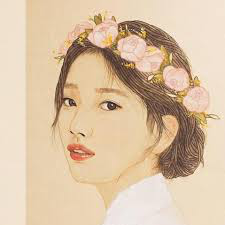

In [49]:
image = Image.open("/content/drive/MyDrive/ml_workplace/YeZak/test_set/동양화_1.jpg")
image



In [50]:
image = transform(image)
model = model.to("cpu")
model.eval()

prediction = model(image.unsqueeze(0))
print(prediction)
prediction = prediction.argmax()

tensor([[ 2.8898e+01,  2.1123e+01,  2.0829e+01,  2.5999e+01,  1.2743e+01,
          1.2786e+01,  1.2267e+01,  3.6019e-02, -2.9716e+00, -7.1547e+00,
          2.0395e+00,  5.6998e+00,  9.1943e-01,  1.9914e+00,  5.1284e+00,
          2.8019e+00,  3.0544e+00,  3.1430e-01,  1.4200e+00,  2.5190e+00,
          7.4336e-01,  5.4625e+00,  4.5887e+00,  2.4168e+00,  1.8511e-01,
         -5.2007e-02,  5.0282e+00, -5.3442e-02, -2.2922e-01,  1.1263e+01,
          7.1128e+00,  1.8877e+00,  3.7905e+00,  8.2264e+00,  4.1881e+00,
          5.4026e+00,  8.3573e+00, -1.3123e+00,  4.0686e+00,  5.0931e+00,
          4.0042e+00,  3.2417e+00,  1.8755e+00,  6.8106e-01,  9.5677e-01,
         -6.4403e-02,  3.3902e+00,  7.7353e-01, -7.5381e-01,  6.5898e+00,
          9.6335e+00,  3.4593e-01, -3.0095e+00, -1.2402e+00, -2.6332e+00,
         -6.3187e-01, -3.4169e+00, -2.5072e+00,  5.9934e+00, -1.1572e+00,
         -8.2181e-02, -1.7547e+00,  3.9856e-01, -5.2376e-02,  4.2053e+00,
          7.4901e+00, -2.1209e+00,  2.

In [51]:
model.fc._parameters

OrderedDict([('weight', Parameter containing:
              tensor([[-0.0195, -0.0703, -0.0476,  ..., -0.0335,  0.1752, -0.0413],
                      [-0.0796, -0.0943,  0.0171,  ...,  0.2065, -0.0244,  0.0368],
                      [-0.0316, -0.0570, -0.0263,  ..., -0.0328, -0.0201,  0.0208],
                      ...,
                      [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
                      [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
                      [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
                     requires_grad=True)), ('bias', Parameter containing:
              tensor([-7.1687e-04,  6.7610e-03,  3.2257e-03, -2.5060e-02,  5.4043e-03,
                       1.3157e-02, -1.1342e-02,  2.0638e-02, -3.6378e-03, -1.2325e-02,
                      -1.2636e-02, -7.2111e-03, -1.9325e-02, -2.4963e-02, -1.1892e-02,
                      -8.3341e-03, -9.5791e-03, -1.6659e-02,  9.1762e-03, -1.5357e-02,


In [52]:
if prediction == 0:
    print("동양화입니다.")
elif prediction == 1:
    print("사실주의 또는 인상주의입니다.")
elif prediction == 2:
    print("애니메이션입니다.")
elif prediction == 3:
    print("추상화 또는 큐비즘 또는 팝아트입니다.")





동양화입니다.


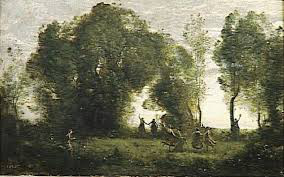

In [53]:
image = Image.open("/content/drive/MyDrive/ml_workplace/YeZak/test_set/사실주의_1.jpg")
image


In [54]:
image = transform(image)
model = model.to("cpu")
model.eval()

prediction = model(image.unsqueeze(0))
print(prediction)
prediction = prediction.argmax()

tensor([[ 2.1767e+01,  2.3006e+01,  2.0895e+01,  1.8455e+01,  1.0421e+01,
          6.5911e+00,  8.1554e+00,  8.4548e-01, -6.8028e-01, -6.5697e+00,
          5.3086e+00,  9.1168e+00,  4.1553e+00,  5.8500e+00,  5.1366e+00,
          5.9209e+00,  7.9813e+00,  1.9204e+00,  3.0385e+00,  7.1577e+00,
          3.1764e+00,  6.7158e+00,  6.4470e+00,  2.6046e+00, -8.6021e-01,
         -1.1281e+00,  4.6892e+00, -1.5428e-01, -1.7189e+00,  8.3476e+00,
          8.8763e+00,  4.2704e+00,  5.6303e+00,  9.7224e+00,  3.9067e+00,
          7.8742e+00,  1.0542e+01,  1.5960e+00,  9.7369e-01,  3.8715e+00,
          5.4352e+00, -9.6376e-01,  2.2974e-01,  1.2821e+00, -1.5607e-01,
          5.5490e-01,  4.8679e+00,  3.4501e-01, -1.9250e+00,  6.6591e+00,
          1.1348e+01, -1.1170e+00, -9.5417e-01,  2.1618e+00, -1.4548e+00,
          3.6540e+00, -6.0061e-01,  5.3095e-01,  1.1354e+01,  1.8117e+00,
          9.4262e-01, -2.6746e-01, -8.9864e-02,  5.7010e-01,  5.7896e+00,
          6.7696e+00, -3.5707e+00,  3.

In [55]:
model.fc._parameters

OrderedDict([('weight', Parameter containing:
              tensor([[-0.0195, -0.0703, -0.0476,  ..., -0.0335,  0.1752, -0.0413],
                      [-0.0796, -0.0943,  0.0171,  ...,  0.2065, -0.0244,  0.0368],
                      [-0.0316, -0.0570, -0.0263,  ..., -0.0328, -0.0201,  0.0208],
                      ...,
                      [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
                      [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
                      [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
                     requires_grad=True)), ('bias', Parameter containing:
              tensor([-7.1687e-04,  6.7610e-03,  3.2257e-03, -2.5060e-02,  5.4043e-03,
                       1.3157e-02, -1.1342e-02,  2.0638e-02, -3.6378e-03, -1.2325e-02,
                      -1.2636e-02, -7.2111e-03, -1.9325e-02, -2.4963e-02, -1.1892e-02,
                      -8.3341e-03, -9.5791e-03, -1.6659e-02,  9.1762e-03, -1.5357e-02,


In [56]:
if prediction == 0:
    print("동양화입니다.")
elif prediction == 1:
    print("사실주의 또는 인상주의입니다.")
elif prediction == 2:
    print("애니메이션입니다.")
elif prediction == 3:
    print("추상화 또는 큐비즘 또는 팝아트입니다.")


사실주의 또는 인상주의입니다.


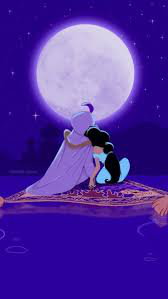

In [57]:
image = Image.open("/content/drive/MyDrive/ml_workplace/YeZak/test_set/알라딘_1.jpg")
image


In [58]:
image = transform(image)
model = model.to("cpu")
model.eval()

prediction = model(image.unsqueeze(0))
print(prediction)
prediction = prediction.argmax()

tensor([[ 1.3655e+01,  1.7974e+01,  2.3612e+01,  2.3574e+01,  1.3998e+01,
          1.2352e+01,  8.7079e+00, -2.6919e-01, -2.1964e+00, -4.7850e+00,
         -1.6112e+00,  5.9011e+00, -9.2279e-01,  3.9916e+00, -1.2099e+00,
          5.1552e-01,  2.6014e+00,  1.7589e-01,  2.8006e+00,  4.2447e+00,
         -2.1256e+00,  4.4370e+00,  5.8224e+00,  1.1743e+00, -5.7556e-01,
         -3.3129e+00, -2.1828e-01, -4.8628e+00, -4.8337e+00,  9.0159e+00,
          2.9559e+00,  3.2703e+00,  1.4845e+00,  1.0729e+01,  5.9703e+00,
          3.3637e-01,  3.1455e+00, -6.5518e+00,  1.1745e+00, -4.1454e-01,
          4.0960e-01, -4.6435e+00, -5.4209e+00, -1.5584e+00, -4.8536e+00,
         -3.3645e+00, -3.2109e-01, -2.1799e+00, -6.8625e+00, -2.9500e-01,
          2.3466e+00,  2.4169e+00, -6.3848e+00, -4.0228e+00, -2.9442e+00,
         -7.4884e-01, -4.9055e+00, -5.1960e+00,  1.8807e+00, -1.1968e+00,
         -8.9130e-01, -2.9989e+00, -4.3377e+00, -2.8095e+00,  1.1756e+00,
          7.3814e+00, -4.1058e+00, -2.

In [59]:
model.fc._parameters

OrderedDict([('weight', Parameter containing:
              tensor([[-0.0195, -0.0703, -0.0476,  ..., -0.0335,  0.1752, -0.0413],
                      [-0.0796, -0.0943,  0.0171,  ...,  0.2065, -0.0244,  0.0368],
                      [-0.0316, -0.0570, -0.0263,  ..., -0.0328, -0.0201,  0.0208],
                      ...,
                      [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
                      [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
                      [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
                     requires_grad=True)), ('bias', Parameter containing:
              tensor([-7.1687e-04,  6.7610e-03,  3.2257e-03, -2.5060e-02,  5.4043e-03,
                       1.3157e-02, -1.1342e-02,  2.0638e-02, -3.6378e-03, -1.2325e-02,
                      -1.2636e-02, -7.2111e-03, -1.9325e-02, -2.4963e-02, -1.1892e-02,
                      -8.3341e-03, -9.5791e-03, -1.6659e-02,  9.1762e-03, -1.5357e-02,


In [60]:
if prediction == 0:
    print("동양화입니다.")
elif prediction == 1:
    print("사실주의 또는 인상주의입니다.")
elif prediction == 2:
    print("애니메이션입니다.")
elif prediction == 3:
    print("추상화 또는 큐비즘 또는 팝아트입니다.")


애니메이션입니다.


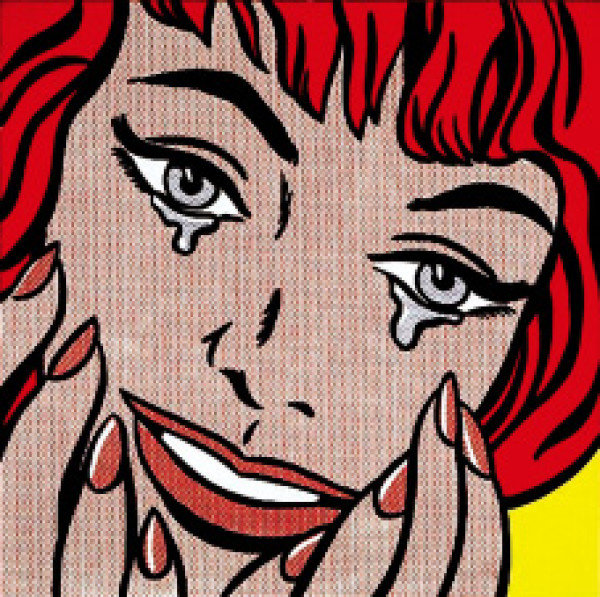

In [61]:
image = Image.open("/content/drive/MyDrive/ml_workplace/YeZak/test_set/팝아트_1.jpg")
image


In [62]:
image = transform(image)
model = model.to("cpu")
model.eval()

prediction = model(image.unsqueeze(0))
print(prediction)
prediction = prediction.argmax()

tensor([[ 1.9307e+01,  1.4259e+01,  2.7085e+01,  3.3611e+01,  1.7897e+01,
          1.8385e+01,  1.6744e+01, -1.8642e+00, -4.1933e+00, -8.3291e+00,
         -1.6672e+00,  1.4307e+00,  3.0848e-03,  1.3110e+00, -8.6606e-02,
         -1.1265e+00, -4.0839e+00, -3.1291e+00,  1.4861e-01,  2.7398e-01,
         -1.6771e+00,  6.1697e-01,  8.9800e-01,  1.5165e+00,  1.0517e+00,
         -2.2826e+00, -3.6016e-01, -2.6257e+00, -2.9697e+00,  6.9174e+00,
         -8.8066e-02, -3.1562e+00, -1.5304e+00,  1.2612e+01,  7.0845e+00,
          1.7215e+00,  6.4268e+00, -4.1742e+00,  2.2764e+00,  3.2796e+00,
         -1.1972e-01, -3.9927e-01, -2.0077e-01,  7.4053e-01, -2.2690e+00,
          6.5267e-01,  7.6600e-01, -2.0973e+00, -1.0589e+00,  8.4779e-01,
          5.9734e+00,  1.1640e+00, -4.1854e+00, -2.5894e+00, -2.2744e+00,
          8.1353e-01, -4.8294e+00, -3.9033e+00,  4.4222e+00, -2.0173e+00,
         -1.5107e+00, -1.1176e+00, -1.3632e+00, -1.8813e+00,  3.2611e+00,
          1.1620e+01, -2.1564e+00,  8.

In [63]:
model.fc._parameters

OrderedDict([('weight', Parameter containing:
              tensor([[-0.0195, -0.0703, -0.0476,  ..., -0.0335,  0.1752, -0.0413],
                      [-0.0796, -0.0943,  0.0171,  ...,  0.2065, -0.0244,  0.0368],
                      [-0.0316, -0.0570, -0.0263,  ..., -0.0328, -0.0201,  0.0208],
                      ...,
                      [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
                      [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
                      [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
                     requires_grad=True)), ('bias', Parameter containing:
              tensor([-7.1687e-04,  6.7610e-03,  3.2257e-03, -2.5060e-02,  5.4043e-03,
                       1.3157e-02, -1.1342e-02,  2.0638e-02, -3.6378e-03, -1.2325e-02,
                      -1.2636e-02, -7.2111e-03, -1.9325e-02, -2.4963e-02, -1.1892e-02,
                      -8.3341e-03, -9.5791e-03, -1.6659e-02,  9.1762e-03, -1.5357e-02,


In [64]:
if prediction == 0:
    print("동양화입니다.")
elif prediction == 1:
    print("사실주의 또는 인상주의입니다.")
elif prediction == 2:
    print("애니메이션입니다.")
elif prediction == 3:
    print("추상화 또는 큐비즘 또는 팝아트입니다.")


추상화 또는 큐비즘 또는 팝아트입니다.
